In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np
import matplotlib.pyplot as plt
import os

In [13]:
def create_encoder(latent_dim, input_dim):
    encoder_input = layers.Input(shape=(input_dim,), name='encoder_input')
    x = encoder_input
    x = layers.Dense(256, activation='relu',
                     kernel_initializer='random_uniform', name='Dense_1')(x)
    x = layers.Dense(256, activation='relu',
                     kernel_initializer='random_uniform', name='Dense_2')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_variance = layers.Dense(latent_dim, name='z_log_variance')(x)
    encoder = Model(inputs=encoder_input, outputs=[z_mean, z_log_variance])
    print('Encoder Network')
    encoder.summary()
    return encoder



In [14]:

def create_decoder(latent_dim, input_dim):
    decoder_input = layers.Input(latent_dim, name='decoder_input')
    x = decoder_input
    x = layers.Dense(256, activation='relu',
                     kernel_initializer='random_uniform', name='Dense_1')(x)
    z_mean_r = layers.Dense(latent_dim, name='z_mean_r')(x)
    z_log_variance_r = layers.Dense(latent_dim, name='z_log_variance_r')(x)
    decoder = Model(decoder_input, [z_mean_r, z_log_variance_r])
    print('Decoder Network')
    decoder.summary()
    return decoder

In [15]:
def calc_VAE_loss(x, z_mean, z_log_var, latent_dim, z_mu_r, z_log_var_r):
    lmbd = 0.5
    reconstuction_loss = K.mean(
        0.5 * z_log_var_r + (K.square(x-z_mu_r)/(2.0 * K.exp(z_log_var_r))), axis=-1)
    kl_loss = - lmbd * K.mean(1 + z_log_var -
                              K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(reconstuction_loss + kl_loss)

In [16]:
def plot_loss(history, plot_path):
    plt.figure(figsize=default_fig_size)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(plot_path)

In [ ]:
def create_VAE(latent_dim, input_dim):
    input_x = layers.Input(shape=input_dim, name='vae_input')
    encoder = create_encoder(latent_dim, input_dim)
    z_mu, z_log_var = encoder(input_x)
    z = layers.Lambda(sampling)([z_mu, z_log_var, latent_dim])

    decoder = create_decoder(latent_dim, input_dim)
    z_mu_r, z_log_var_r = decoder(z)
    vae = Model(input_x, [z_mu_r, z_log_var_r])
    loss_vae = calc_VAE_loss(input_x, z_mu, z_log_var,
                             latent_dim, z_mu_r, z_log_var_r)
    vae.add_loss(loss_vae)
    vae.compile(optimizer='adam')
    return vae, decoder, encoder

In [ ]:
def sampling(args):
    z_mean, z_log_var, latent_dim = args
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon


In [ ]:

def fit_model(vae, decoder, encoder, nb_epochs, current_epoch, batch_size, callbacks, version, data, latent_dim):
    x_train, x_test = data

    history = vae.fit(x_train, epochs=nb_epochs, batch_size=batch_size,
                      callbacks=callbacks, verbose=2, validation_data=(x_test, None))

    decoder_base_path = f'./{path_name}/{model_name}/decoders/'
    encoder_base_path = f'./{path_name}/{model_name}/encoders/'
    plot_base_path = f'./{path_name}/{model_name}/plots/'

    if not os.path.exists(decoder_base_path):
        os.makedirs(decoder_base_path)
    if not os.path.exists(encoder_base_path):
        os.makedirs(encoder_base_path)
    if not os.path.exists(plot_base_path):
        os.makedirs(plot_base_path)

    decoder_path = decoder_base_path+'decoder_v'+str(version)+'_' + \
        str(current_epoch)+'_epochs.h5'
    encoder_path = encoder_base_path+'encoder_v'+str(version)+'_' + \
        str(current_epoch)+'_epochs.h5'
    plot_path = plot_base_path+'plot_v'+str(version) + \
        '_'+str(current_epoch)+'_epochs.png'
    decoder.save(decoder_path)
    encoder.save(encoder_path)
    plot_loss(history, plot_path)


In [ ]:
def run_gvae(version, epochs, data, latent_dim = 2, batch_size = 128):
    vae, decoder, encoder = create_VAE(data[0].shape[1], data[0].shape[1])
    callbacks = [
                EarlyStopping(
                    monitor="val_loss", mode="min", patience=10, verbose=1),
              ReduceLROnPlateau(monitor="val_loss", mode="min",
                          patience=5, verbose=1)
            ]
    fit_model(vae, decoder, encoder, epochs, epochs,
              batch_size, callbacks, version, data, latent_dim)

In [8]:
file = 'data/Hz31.txt'
data = np.loadtxt(file)
input_len = len(data)
data.shape

(31, 3)

In [9]:
x = data[:, 0:2]
y = data[:, 1]
err = data[:, 2]
print(x.shape, err.shape)

(31, 2) (31,)


In [10]:
randomize = np.random.permutation(input_len)
x = x[randomize]
y = y[randomize]
err = err[randomize]
data = data[randomize]

# maxX = np.max(x)
# minX = np.min(x)
ntrain = int(0.8 * input_len)
indx = [ntrain]
x_train, x_test = np.split(x, indx)
# data_train, data_test = np.split(data, indx)



Encoder Network
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 2)]          0                                            
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 256)          768         encoder_input[0][0]              
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 256)          65792       Dense_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         Dense_2[0][0]                    
____________________________________________________________________________

Epoch 77/500
6/6 - 0s - loss: 37.8997 - val_loss: 35.0094 - lr: 0.0010
Epoch 78/500
6/6 - 0s - loss: 37.8960 - val_loss: 35.0802 - lr: 0.0010
Epoch 79/500
6/6 - 0s - loss: 36.7987 - val_loss: 33.7370 - lr: 0.0010
Epoch 80/500
6/6 - 0s - loss: 36.9433 - val_loss: 33.2401 - lr: 0.0010
Epoch 81/500

Epoch 00081: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6/6 - 0s - loss: 36.8924 - val_loss: 33.3508 - lr: 0.0010
Epoch 82/500
6/6 - 0s - loss: 35.5721 - val_loss: 34.0338 - lr: 1.0000e-04
Epoch 83/500
6/6 - 0s - loss: 35.6318 - val_loss: 32.8833 - lr: 1.0000e-04
Epoch 84/500
6/6 - 0s - loss: 36.6629 - val_loss: 32.6243 - lr: 1.0000e-04
Epoch 85/500
6/6 - 0s - loss: 35.6392 - val_loss: 32.9988 - lr: 1.0000e-04
Epoch 86/500

Epoch 00086: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
6/6 - 0s - loss: 36.0707 - val_loss: 33.6224 - lr: 1.0000e-04
Epoch 00086: early stopping


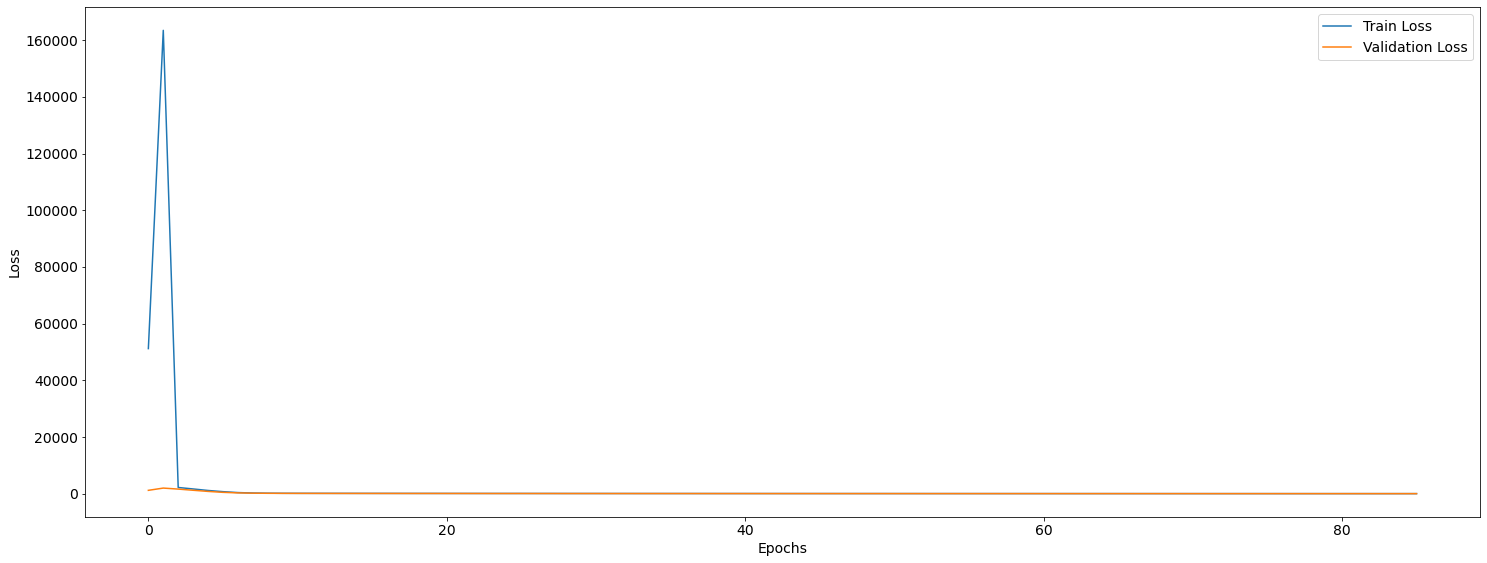

In [11]:
plt.rc('font', size=14)


def to_inch(pix):
    dpi = 96
    return pix / dpi


w = to_inch(2400)
h = to_inch(900)
default_fig_size = (w, h)

path_name = 'models'
model_name = 'GVAE'
batch_size = 4
version = 1
epochs = 500
latent_dim = x_train.shape[1]
# latent_dim = data_train.shape[1]
# run_gvae(version, epochs, (data_train, data_test), latent_dim, batch_size)
run_gvae(version, epochs, (x_train, x_test), latent_dim, batch_size)

In [12]:
decoder_name = f'decoder_V{version}_{epochs}_epochs'
predicted_sample = True

In [24]:
# Load the model
decofile = 'models/GVAE/decoders/decoder_v1_500_epochs.h5'
model = load_model(decofile, compile = True)

In [25]:
model.compile()

In [26]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, 2)]          0                                            
__________________________________________________________________________________________________
Dense_1 (Dense)                 (None, 256)          768         decoder_input[0][0]              
__________________________________________________________________________________________________
z_mean_r (Dense)                (None, 2)            514         Dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_variance_r (Dense)        (None, 2)            514         Dense_1[0][0]                    
Total params: 1,796
Trainable params: 1,796
Non-trainable params: 0
________________________

In [27]:
latent_dim

2

In [29]:
samples_to_predict = np.random.rand(2)
print(samples_to_predict.shape)

(2,)


In [30]:
np.random.rand(2)

array([0.05509432, 0.82742755])

In [40]:
# Generate predictions for samples
predictions = model.predict(np.array([0.05, 0.004]))
print(predictions)

ValueError: in user code:

    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1122 predict_step  **
        return self(x, training=False)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:719 call
        convert_kwargs_to_constants=base_layer_utils.call_context().saving)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/isidro/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer Dense_1 is incompatible with the layer: expected axis -1 of input shape to have value 2 but received input with shape [None, 1]
